In [113]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import ast
import eli5

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline

from wordcloud import WordCloud
from collections import Counter
from PIL import Image
from urllib.request import urlopen
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
## Data Loading & Cleaning

In [3]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [4]:
dict_columns = ['belongs_to_collection', 'genres', 'production_companies', 
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
train = text_to_dict(train)
test = text_to_dict(test)

In [5]:
train.head(2)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435


In [6]:
train.shape, test.shape

((3000, 23), (4398, 22))

**belongs_to_collection**

In [7]:
for i, e in enumerate(train['belongs_to_collection'][:5]):
    print(i, e)

0 [{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
1 [{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
2 {}
3 {}
4 {}


In [8]:
train['belongs_to_collection'].apply(lambda x : len(x) if x != {} else 0).value_counts()

0    2396
1     604
Name: belongs_to_collection, dtype: int64

In [9]:
train['collection_name'] = train['belongs_to_collection'].apply(lambda x : x[0]['name'] if x != {} else 0)
train['has_collection'] = train['belongs_to_collection'].apply(lambda x : len(x) if x != {} else 0)

test['collection_name'] = test['belongs_to_collection'].apply(lambda x : x[0]['name'] if x != {} else 0)
test['has_collection'] = test['belongs_to_collection'].apply(lambda x : len(x) if x != {} else 0)

train.drop(['belongs_to_collection'], axis=1, inplace=True)
test.drop(['belongs_to_collection'], axis=1, inplace=True)

**genres**

In [10]:
for i, e in enumerate(train['genres'][:5]):
    print(i, e)

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]


In [11]:
print('Number of genres in films.')
train['genres'].apply(lambda x : len(x) if x != {} else 0).value_counts()

Number of genres in films.


2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64

In [12]:
list_of_genres = list(train['genres'].apply(lambda x : [i['name'] for i in x] if x != {} else []).values)

In [13]:
list_of_genres[:5]

[['Comedy'],
 ['Comedy', 'Drama', 'Family', 'Romance'],
 ['Drama'],
 ['Thriller', 'Drama'],
 ['Action', 'Thriller']]

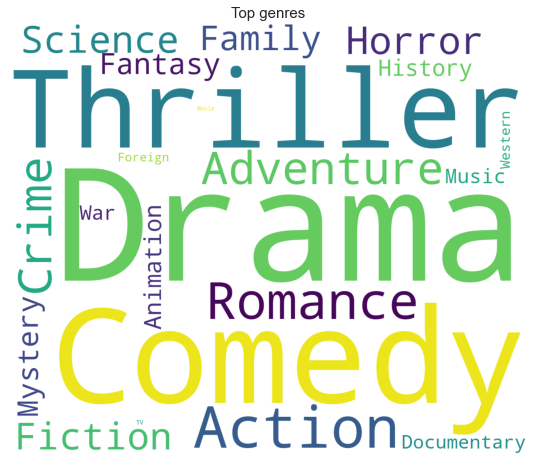

In [14]:
text = ' '.join([i for j in list_of_genres for i in j])
wordcloud = WordCloud(max_font_size=None, 
                      background_color='white', 
                      collocations=False, 
                      width=1200, height=1000).generate(text)

plt.figure(figsize = (12, 8))
plt.imshow(wordcloud)
plt.title('Top genres', fontsize=15)
plt.axis('off');

In [15]:
Counter([i for j in list_of_genres for i in j]).most_common()

[('Drama', 1531),
 ('Comedy', 1028),
 ('Thriller', 789),
 ('Action', 741),
 ('Romance', 571),
 ('Crime', 469),
 ('Adventure', 439),
 ('Horror', 301),
 ('Science Fiction', 290),
 ('Family', 260),
 ('Fantasy', 232),
 ('Mystery', 225),
 ('Animation', 141),
 ('History', 132),
 ('Music', 100),
 ('War', 100),
 ('Documentary', 87),
 ('Western', 43),
 ('Foreign', 31),
 ('TV Movie', 1)]

In [16]:
train['num_genres'] = train['genres'].apply(lambda x : len(x) if x != {} else 0)
train['all_genres'] = train['genres'].apply(lambda x : ' '.join(sorted(i['name'] for i in x)) if i != {} else '')
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
for g in top_genres:
    train['genre_'+g] = train['all_genres'].apply(lambda x : 1 if g in x else 0)
    
test['num_genres'] = test['genres'].apply(lambda x : len(x) if x != {} else 0)
test['all_genres'] = test['genres'].apply(lambda x : ' '.join(sorted(i['name'] for i in x)) if i != {} else '')
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
for g in top_genres:
    test['genre_'+g] = test['all_genres'].apply(lambda x : 1 if g in x else 0)
    
train = train.drop(['genres'], axis=1)
test = test.drop(['genres'], axis=1)

**production_companies**

In [17]:
for i, e in enumerate(train['production_companies'][:5]):
    print(i, e)

0 [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
1 [{'name': 'Walt Disney Pictures', 'id': 2}]
2 [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
3 {}
4 {}


In [18]:
print('Number of production companies in films.')
train['production_companies'].apply(lambda x : len(x) if x != {} else 0).value_counts()

Number of production companies in films.


1     775
2     734
3     582
4     312
5     166
0     156
6     118
7      62
8      42
9      29
11      7
10      7
12      3
16      2
15      2
14      1
13      1
17      1
Name: production_companies, dtype: int64

In [19]:
train[train['production_companies'].apply(lambda x : len(x) if x != {} else 0) > 11]

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music
31,32,0,http://www.cache-derfilm.at,tt0387898,fr,Caché,A married couple is terrorized by a series of ...,5.695860,/i1Zl8S4DgM3IDLW5dhZzBnIdCOe.jpg,"[{'name': 'Les Films du Losange', 'id': 223}, ...","[{'iso_3166_1': 'AT', 'name': 'Austria'}, {'is...",5/2/05,117.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,NaN,Caché,"[{'id': 90, 'name': 'paris'}, {'id': 213, 'nam...","[{'cast_id': 2, 'character': 'Georges Laurent'...","[{'credit_id': '52fe4244c3a36847f8011073', 'de...",36000000,0,0,3,Drama Mystery Thriller,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0
116,117,0,NaN,tt2113822,zh,一九四二,"In 1942, Henan Province was devastated by the ...",1.678013,/xxz2gi8vijqqJySGO3kQy2i8mv.jpg,"[{'name': 'Emperor Motion Pictures', 'id': 272...","[{'iso_3166_1': 'CN', 'name': 'China'}]",11/1/12,145.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Back to 1942,"[{'id': 478, 'name': 'china'}, {'id': 180999, ...","[{'cast_id': 3, 'character': 'Theodore Harold ...","[{'credit_id': '5761375dc3a36808aa001554', 'de...",311,0,0,1,Drama,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
363,364,15400000,NaN,tt2053425,fr,De rouille et d'os,"Put in charge of his young son, Ali leaves Bel...",8.400049,/cHCwW8xPl8yPKQwpNzKVinwvirT.jpg,"[{'name': 'France 2 Cinéma', 'id': 83}, {'name...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",5/17/12,123.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Rust and Bone,"[{'id': 494, 'name': 'father son relationship'...","[{'cast_id': 2, 'character': 'St√©phanie', 'cr...","[{'credit_id': '52fe49dd9251416c750d5e05', 'de...",25762027,0,0,2,Drama Romance,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
392,393,0,NaN,tt5072406,fr,Moka,Diane Kramer is led by one obsession: to find ...,2.404466,/5VKVaTJJsyDeOzY6fLcyTo1RA9g.jpg,"[{'name': 'Canal+', 'id': 5358}, {'name': 'Cin...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",8/17/16,89.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,NaN,Moka,{},"[{'cast_id': 1, 'character': 'Diane', 'credit_...","[{'credit_id': '59619ddd9251410bfa0cf8e5', 'de...",126463,0,0,1,Drama,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
449,450,80000000,http://asoundofthunder.warnerbros.com/,tt0318081,en,A Sound of Thunder,When a hunter sent back to the prehistoric era...,4.980191,/gsqOX1ReJ5lcmTuDdkhOXLug8Ug.jpg,"[{'name': 'Epsilon Motion Pictures', 'id': 117...","[{'iso_3166_1': 'CZ', 'name': 'Czech Republic'...",5/15/05,110.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Some Rules Should Never Be Broken.,A Sound of Thunder,"[{'id': 3737, 'name': 'dying and death'}, {'id...","[{'cast_id': 34, 'character': 'Alicia Wallenbe...","[{'credit_id': '52fe431e9251416c7500438b', 'de...",5989640,0,0,4,Action Adventure Science Fiction Thriller,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0
554,555,14500000,NaN,tt0293416,ja,Metropolis,Duke Red has overseen the construction of a ma...,9.298092,/1EK7mGCpRKYmSg25FaojvnS9opm.jpg,"[{'name': 'Bandai Visual Company', 'id': 528},...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",5/26/01,108.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}, {'iso...",Released,Welcome to Metropolis,Metropolis,"[{'id': 931, 'name': 'jealousy'}, {'id': 1761,...","[{'cast_id': 1, 'character': 'Tima (voice)', '...","[{'credit_id': '52fe4510c3a36847f80ba41d', 'de...",95789342,0,0,2,Animation Science Fiction,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1079,1080,7000000,NaN,tt2737050,fr,"Deux jours, une nuit",Sandra is a young woman who has only one weeke...,6.868022,/1mYAejpMskvskGr0J0SaBvdjmrH.jpg,"[{'name': 'BIM Distribuzione', 'id': 225}, {'n...","[{'iso_

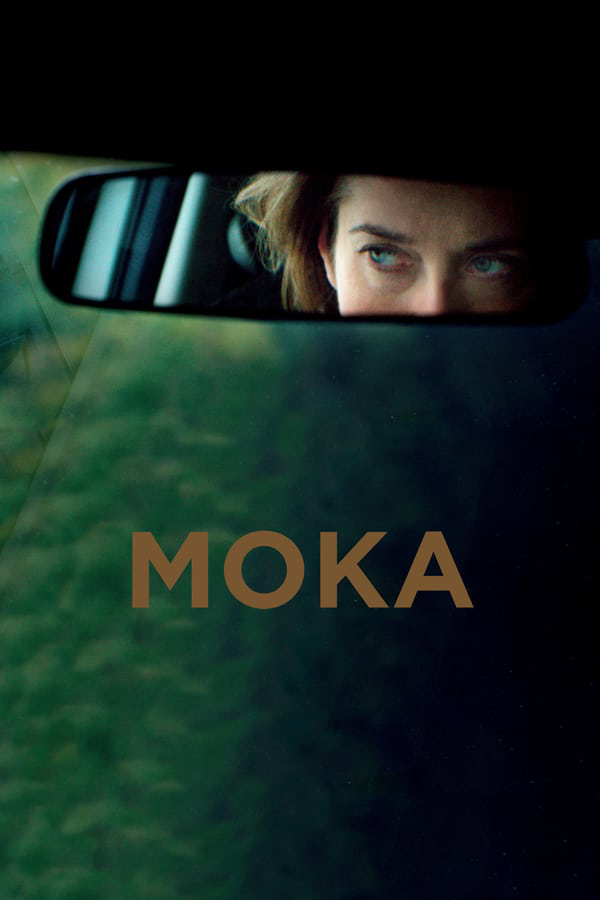

In [20]:
# example of poster such a film
img = Image.open(urlopen("https://image.tmdb.org/t/p/w600_and_h900_bestv2/5VKVaTJJsyDeOzY6fLcyTo1RA9g.jpg"))
img

In [21]:
list_of_companies = list(train['production_companies'].apply(
    lambda x : [i['name'] for i in x] if x != {} else []).values)

In [22]:
Counter(i for j in list_of_companies for i in j).most_common(30)[:5]

[('Warner Bros.', 202),
 ('Universal Pictures', 188),
 ('Paramount Pictures', 161),
 ('Twentieth Century Fox Film Corporation', 138),
 ('Columbia Pictures', 91)]

In [23]:
train['num_companies'] = train['production_companies'].apply(lambda x : len(x) if x != {} else 0)
train['all_production_companies'] = train['production_companies'].apply(
    lambda x : ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]

for g in top_companies:
    train['production_company_'+g] = train['all_production_companies'].apply(
        lambda x : 1 if g in x else 0)
    
test['num_companies'] = test['production_companies'].apply(lambda x : len(x) if x != {} else 0)
test['all_production_companies'] = test['production_companies'].apply(
    lambda x : ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]

for g in top_companies:
    test['production_company_'+g] = test['all_production_companies'].apply(
        lambda x : 1 if g in x else 0)
    
train = train.drop(['production_companies', 'all_production_companies'], axis=1)
test = test.drop(['production_companies', 'all_production_companies'], axis=1)

**production_countries**

In [24]:
for i, e in enumerate(train['production_countries'][:5]):
    print(i, e)

0 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
1 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
2 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
3 [{'iso_3166_1': 'IN', 'name': 'India'}]
4 [{'iso_3166_1': 'KR', 'name': 'South Korea'}]


In [25]:
print('Nmuber of production countries in films.')
train['production_countries'].apply(lambda x : len(x) if x != {} else 0).value_counts()

Nmuber of production countries in films.


1    2222
2     525
3     116
4      57
0      55
5      21
6       3
8       1
Name: production_countries, dtype: int64

In [26]:
list_of_countries = list(train['production_countries'].apply(
    lambda x :[i['name'] for i in x] if x != {} else []).values)

In [27]:
Counter(i for j in list_of_countries for i in j).most_common(30)[:5]

[('United States of America', 2282),
 ('United Kingdom', 380),
 ('France', 222),
 ('Germany', 167),
 ('Canada', 120)]

In [28]:
train['num_countries'] = train['production_countries'].apply(lambda x: len(x) if x != {} else 0)
train['all_countries'] = train['production_countries'].apply(
    lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(30)]

for g in top_countries:
    train['production_country_' + g] = train['all_countries'].apply(lambda x: 1 if g in x else 0)
    
test['num_countries'] = test['production_countries'].apply(lambda x: len(x) if x != {} else 0)
test['all_countries'] = test['production_countries'].apply(
    lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_countries:
    test['production_country_' + g] = test['all_countries'].apply(lambda x: 1 if g in x else 0)
    
train = train.drop(['production_countries', 'all_countries'], axis=1)
test = test.drop(['production_countries', 'all_countries'], axis=1)

**spoken_languages**

In [29]:
for i, e in enumerate(train['spoken_languages'][:5]):
    print(i, e)

0 [{'iso_639_1': 'en', 'name': 'English'}]
1 [{'iso_639_1': 'en', 'name': 'English'}]
2 [{'iso_639_1': 'en', 'name': 'English'}]
3 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
4 [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]


In [30]:
print('Number of spoken languages in films.')
train['spoken_languages'].apply(lambda x : len(x) if x != {} else 0).value_counts()

Number of spoken languages in films.


1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: spoken_languages, dtype: int64

In [31]:
list_of_languages = list(train['spoken_languages'].apply(
    lambda x : [i['name'] for i in x] if x != {} else []).values)

In [32]:
Counter([i for j in list_of_languages for i in j]).most_common(15)

[('English', 2618),
 ('Français', 288),
 ('Español', 239),
 ('Deutsch', 169),
 ('Pусский', 152),
 ('Italiano', 124),
 ('日本語', 89),
 ('普通话', 68),
 ('हिन्दी', 56),
 ('', 47),
 ('Português', 43),
 ('العربية', 40),
 ('한국어/조선말', 37),
 ('广州话 / 廣州話', 36),
 ('தமிழ்', 27)]

In [33]:
train['num_languages'] = train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
train['all_languages'] = train['spoken_languages'].apply(
    lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_languages = [m[0] for m in Counter([i for j in list_of_languages for i in j]).most_common(30)]

for g in top_languages:
    train['language_' + g] = train['all_languages'].apply(lambda x: 1 if g in x else 0)
    
test['num_languages'] = test['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
test['all_languages'] = test['spoken_languages'].apply(
    lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

for g in top_languages:
    test['language_' + g] = test['all_languages'].apply(lambda x: 1 if g in x else 0)
    
train = train.drop(['spoken_languages', 'all_languages'], axis=1)
test = test.drop(['spoken_languages', 'all_languages'], axis=1)

**keywords**

In [34]:
for i, e in enumerate(train['Keywords'][:5]):
    print(i, e)

0 [{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
1 [{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]
2 [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]
3 [{'id': 10092, 'name': 'mystery'}, {'id': 10540, 'name': 'bollywood'}, {'id': 11734, 'name': 'police corruption'}, {'id': 14536, 'name': 'crime'}, {'id': 14636, 'name': 'india'}, {'id': 208364, 'name': 'missing husband'}, {'id': 220935, 'name': 'ne

In [35]:
print('Number of keywords in films.')
train['Keywords'].apply(lambda x : len(x) if x != {} else 0).value_counts()[:5]

Number of keywords in films.


5    293
0    276
4    248
3    228
6    227
Name: Keywords, dtype: int64

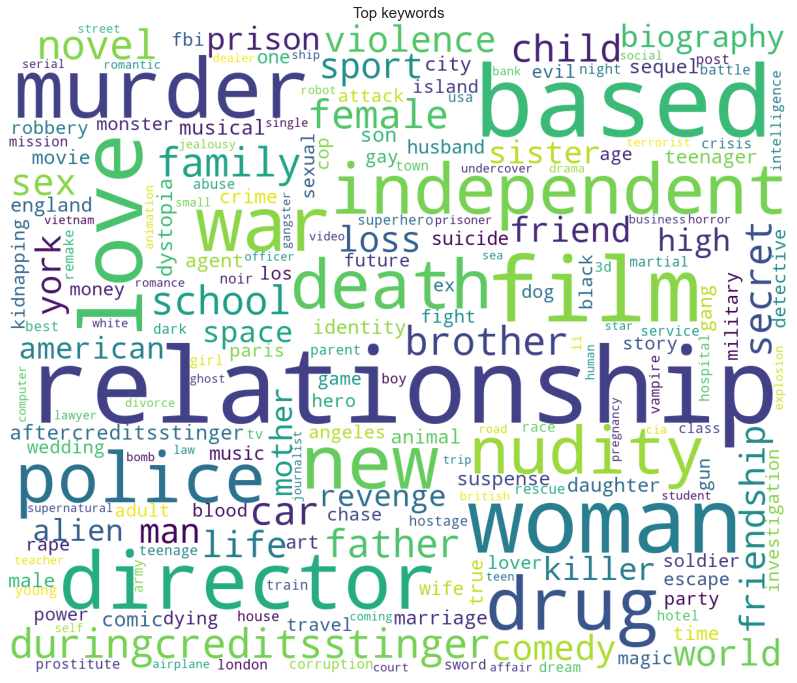

In [36]:
list_of_keywords = list(train['Keywords'].apply(lambda x : [i['name'] for i in x] if x != {} else []).values)

text = ' '.join([i for j in list_of_keywords for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False, 
                      width=1200, height=1000).generate(text)

plt.figure(figsize=(16, 12))
plt.imshow(wordcloud)
plt.title('Top keywords', fontsize=15)
plt.axis('off');

In [37]:
train['num_Keywords'] = train['Keywords'].apply(lambda x: len(x) if x != {} else 0)
train['all_Keywords'] = train['Keywords'].apply(
    lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_keywords = [m[0] for m in Counter([i for j in list_of_keywords for i in j]).most_common(30)]

for g in top_keywords:
    train['keyword_' + g] = train['all_Keywords'].apply(lambda x: 1 if g in x else 0)
    
test['num_Keywords'] = test['Keywords'].apply(lambda x: len(x) if x != {} else 0)
test['all_Keywords'] = test['Keywords'].apply(
    lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

for g in top_keywords:
    test['keyword_' + g] = test['all_Keywords'].apply(lambda x: 1 if g in x else 0)
    
train = train.drop(['Keywords', 'all_Keywords'], axis=1)
test = test.drop(['Keywords', 'all_Keywords'], axis=1)

**cast**

In [38]:
for i, e in enumerate(train['cast'][:1]):
    print(i, e)

0 [{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'characte

In [39]:
print('Number of casted person in films.')
train['cast'].apply(lambda x : len(x) if x != {} else 0).value_counts()[:10]

Number of casted person in films.


15    212
16    165
10    135
13    129
12    124
11    122
9     118
17    118
18    115
14    110
Name: cast, dtype: int64

In [40]:
list_of_cast_names = list(train['cast'].apply(
    lambda x : [i['name'] for i in x] if x != {} else[]).values)
Counter([i for j in list_of_cast_names for i in j]).most_common(20)

[('Samuel L. Jackson', 30),
 ('Robert De Niro', 30),
 ('Morgan Freeman', 27),
 ('J.K. Simmons', 25),
 ('Bruce Willis', 25),
 ('Liam Neeson', 25),
 ('Susan Sarandon', 25),
 ('Bruce McGill', 24),
 ('John Turturro', 24),
 ('Forest Whitaker', 23),
 ('Willem Dafoe', 23),
 ('Bill Murray', 22),
 ('Owen Wilson', 22),
 ('Nicolas Cage', 22),
 ('Sylvester Stallone', 21),
 ('Jason Statham', 21),
 ('Keith David', 21),
 ('John Goodman', 21),
 ('Mel Gibson', 21),
 ('Sigourney Weaver', 21)]

1 -> Female, 2 -> Male, 0 -> unspecified

In [41]:
list_of_cast_genders = list(train['cast'].apply(
    lambda x : [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_genders for i in j]).most_common()

[(2, 27949), (0, 20329), (1, 13533)]

In [42]:
train['num_cast'] = train['cast'].apply(lambda x : len(x) if x != {} else 0)
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(20)]

for g in top_cast_names:
    train['cast_name_'+g] = train['cast'].apply(lambda x : 1 if x != {} else 0)
    
train['gender_0_cast'] = train['cast'].apply(lambda x : sum([1 for i in x if i['gender']==0]))
train['gender_1_cast'] = train['cast'].apply(lambda x : sum([1 for i in x if i['gender']==1]))
train['gender_2_cast'] = train['cast'].apply(lambda x : sum([1 for i in x if i['gender']==2]))

test['num_cast'] = test['cast'].apply(lambda x : len(x) if x != {} else 0)
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(20)]

for g in top_cast_names:
    test['cast_name_'+g] = test['cast'].apply(lambda x : 1 if x != {} else 0)
    
test['gender_0_cast'] = test['cast'].apply(lambda x : sum([1 for i in x if i['gender']==0]))
test['gender_1_cast'] = test['cast'].apply(lambda x : sum([1 for i in x if i['gender']==1]))
test['gender_2_cast'] = test['cast'].apply(lambda x : sum([1 for i in x if i['gender']==2]))

train = train.drop(['cast'], axis=1)
test = test.drop(['cast'], axis=1)

**crew**

In [43]:
for i, e in enumerate(train['crew'][:1]):
    print(i, e)

0 [{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071, 'job': 'First Assistant Director', 'name': 'Kelly Cantley', 'profile_path': None}, {'credit_id': '52fe4ee7c3a36847f82afad7', 'department': 'Directing', 'gender': 2, 'id': 3227, 'job': 'Director', 'name': 'Steve Pink', 'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'}, {'credit_id': '5524ed25c3a3687ded000d88', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Writer', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed2d925141720c001128', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Characters', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed3d92514166c1004a5d', 'department': 'Production', 'gender': 2, 'id': 57822, 'job': 'Producer', 'name': 'Andrew Panay', 'profile_path': None}, {'credit_id': '5524ed4bc3a3687df3000dd2', 'department': 'Production', 'gender': 0, 'id': 14

In [44]:
print('Number of crew in films.')
train['crew'].apply(lambda x : len(x) if x != {} else 0).value_counts()[:10]

Number of crew in films.


2     179
11    127
10    126
3     126
12    110
9     109
8     109
14    104
4     101
7      94
Name: crew, dtype: int64

In [45]:
list_of_crew_names = list(train['crew'].apply(
    lambda x : [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_names for i in j]).most_common(15)

[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Steven Spielberg', 37),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Bob Weinstein', 30),
 ('Harvey Weinstein', 30),
 ('Janet Hirshenson', 30)]

In [46]:
list_of_crew_jobs = list(train['crew'].apply(
    lambda x : [i['job'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)

[('Producer', 6011),
 ('Executive Producer', 3459),
 ('Director', 3225),
 ('Screenplay', 2996),
 ('Editor', 2824),
 ('Casting', 2483),
 ('Director of Photography', 2288),
 ('Original Music Composer', 1947),
 ('Art Direction', 1821),
 ('Production Design', 1650),
 ('Costume Design', 1573),
 ('Writer', 1523),
 ('Set Decoration', 1345),
 ('Makeup Artist', 1108),
 ('Sound Re-Recording Mixer', 970)]

In [47]:
list_of_crew_genders = list(train['crew'].apply(
    lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_genders for i in j]).most_common(15)

[(0, 41787), (2, 24898), (1, 6412)]

In [48]:
train['num_crew'] = train['crew'].apply(lambda x : len(x) if x != {} else 0)
top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(15)]
for g in top_crew_names:
    train['crew_name_'+g] = train['crew'].apply(lambda x : 1 if g in x else 0)

train['gender_0_crew'] = train['crew'].apply(lambda x : sum([1 for i in x if i['gender'] == 0]))
train['gender_1_crew'] = train['crew'].apply(lambda x : sum([1 for i in x if i['gender'] == 1]))
train['gender_2_crew'] = train['crew'].apply(lambda x : sum([1 for i in x if i['gender'] == 2]))

top_crew_jobs = [m[0] for m in Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)]
for j in top_crew_jobs:
    train['crew_job_'+j] = train['crew'].apply(lambda x : sum([1 for i in x if i['job'] == j]))
    
test['num_crew'] = test['crew'].apply(lambda x : len(x) if x != {} else 0)
top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(15)]
for g in top_crew_names:
    test['crew_name_'+g] = test['crew'].apply(lambda x : 1 if g in x else 0)

test['gender_0_crew'] = test['crew'].apply(lambda x : sum([1 for i in x if i['gender'] == 0]))
test['gender_1_crew'] = test['crew'].apply(lambda x : sum([1 for i in x if i['gender'] == 1]))
test['gender_2_crew'] = test['crew'].apply(lambda x : sum([1 for i in x if i['gender'] == 2]))

top_crew_jobs = [m[0] for m in Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)]
for j in top_crew_jobs:
    test['crew_job_'+j] = test['crew'].apply(lambda x : sum([1 for i in x if i['job'] == j]))
    
train = train.drop(['crew'], axis=1)
test = test.drop(['crew'], axis=1)

## Data Exploration

In [49]:
train.head()

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,revenue,collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,production_company_Regency Enterprises,production_company_BBC Films,production_company_Dune Entertainment,production_company_Working Title Films,production_company_Fox Searchlight Pictures,production_company_StudioCanal,production_company_Lionsgate,production_company_DreamWorks SKG,production_company_Fox 2000 Pictures,production_company_Summit Entertainment,production_company_Hollywood Pictures,production_company_Orion Pictures,production_company_Amblin Entertainment,production_company_Dimension Films,num_countries,production_country_United States of America,production_country_United Kingdom,production_country_France,production_country_Germany,production_country_Canada,production_country_India,production_country_Italy,production_country_Japan,production_country_Australia,production_country_Russia,production_country_Spain,production_country_China,production_country_Hong Kong,production_country_Ireland,production_country_Belgium,production_country_South Korea,production_country_Mexico,production_country_Sweden,production_country_New Zealand,production_country_Netherlands,production_country_Czech Republic,production_country_Denmark,production_country_Brazil,production_country_Luxembourg,production_country_South Africa,production_country_Hungary,production_country_United Arab Emirates,production_country_Austria,production_country_Switzerland,production_country_Romania,num_languages,language_English,language_Français,language_Español,language_Deutsch,language_Pусский,language_Italiano,language_日本語,language_普通话,language_हिन्दी,language_,language_Português,language_العربية,language_한국어/조선말,language_广州话 / 廣州話,language_தமிழ்,language_Polski,language_Magyar,language_Latin,language_svenska,language_ภาษาไทย,language_Český,language_עִבְרִית,language_ελληνικά,language_Türkçe,language_Dansk,language_Nederlands,language_فارسی,language_Tiếng Việt,language_اردو,language_Română,num_Keywords,keyword_woman director,keyword_independent film,keyword_duringcreditsstinger,keyword_murder,keyword_based on novel,keyword_violence,keyword_sport,keyword_biography,keyword_aftercreditsstinger,keyword_dystopia,keyword_revenge,keyword_friendship,keyword_sex,keyword_suspense,keyword_sequel,keyword_love,keyword_police,keyword_teenager,keyword_nudity,keyword_female nudity,keyword_drug,keyword_prison,keyword_musical,keyword_high school,keyword_los angeles,keyword_new york,keyword_family,keyword_father son relationship,keyword_kidnapping,keyword_investigation,num_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_Morgan Freeman,cast_name_J.K. Simmons,cast_name_Bruce Willis,cast_name_Liam Neeson,cast_name_Susan Sarandon,cast_name_Bruce McGill,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,cast_name_Jason Statham,cast_name_Keith David,cast_name_John Goodman,cast_name_Mel Gibson,cast_name_Sigourney Weaver,gen

### target
Using log to make it to close normal distribution since it has a hight skewness.

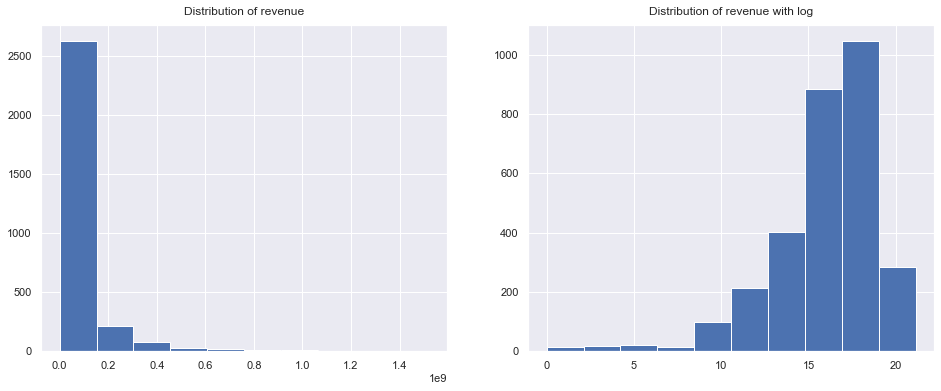

In [50]:
fig, ax = plt.subplots(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.hist(train['revenue'])
plt.title('Distribution of revenue', fontsize=12, pad=10)

plt.subplot(1, 2, 2)
plt.hist(np.log(train['revenue']))
plt.title('Distribution of revenue with log', fontsize=12, pad=10);

In [51]:
train['log_revenue'] = np.log(train['revenue'])

### Budget
Using log to make it to close normal distribution since it has a hight skewness.

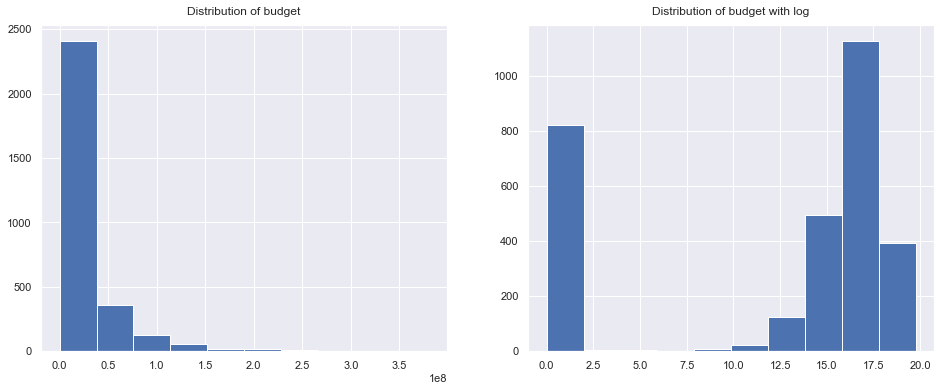

In [52]:
fig, ax = plt.subplots(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.hist(train['budget'])
plt.title('Distribution of budget', fontsize=12, pad=10)

plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['budget']))
plt.title('Distribution of budget with log', fontsize=12, pad=10);

The correlation between revenue and budget

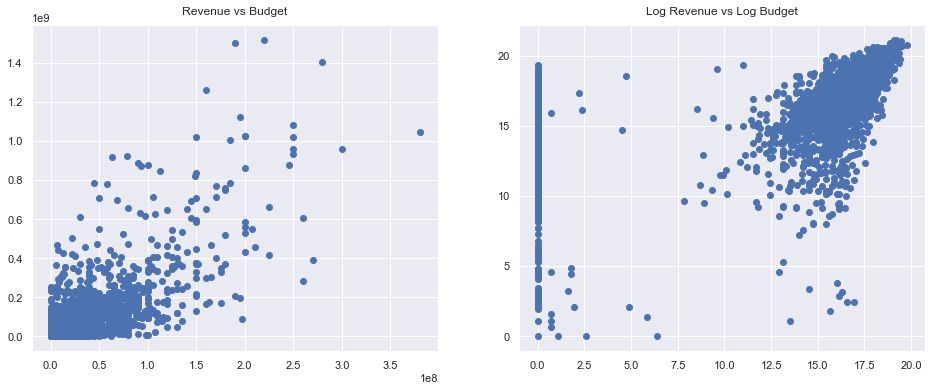

In [53]:
fig, ax = plt.subplots(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.scatter(train['budget'], train['revenue'])
plt.title('Revenue vs Budget', fontsize=12, pad=10)

plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['budget']), train['log_revenue'])
plt.title('Log Revenue vs Log Budget', fontsize=12, pad=10);

In [54]:
train['log_budget'] = np.log1p(train['budget'])
test['log_budget'] = np.log1p(test['budget'])

### homepage
Films with homepage tend to generate more revenue.

In [55]:
train['homepage'].value_counts()

http://www.transformersmovie.com/                          4
http://www.lordoftherings.net/                             2
http://www.thehobbit.com/                                  2
http://www.paramountvantage.com/virginsuicides/html_3/     1
http://www.bottleshockthemovie.com/                        1
                                                          ..
https://www.facebook.com/LondonHasFallenOfficial           1
http://waltzwithbashir.com                                 1
http://howtobesinglemovie.com/                             1
http://angeleyesmovie.warnerbros.com/index_noflash.html    1
http://www.thebookthief.com/                               1
Name: homepage, Length: 941, dtype: int64

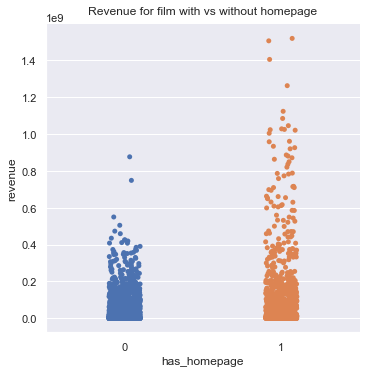

In [56]:
train['has_homepage'] = 0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1
test['has_homepage'] = 0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1

sns.catplot(x='has_homepage', y='revenue', data=train)
plt.title('Revenue for film with vs without homepage', fontsize=12, pad=10);

### original_language

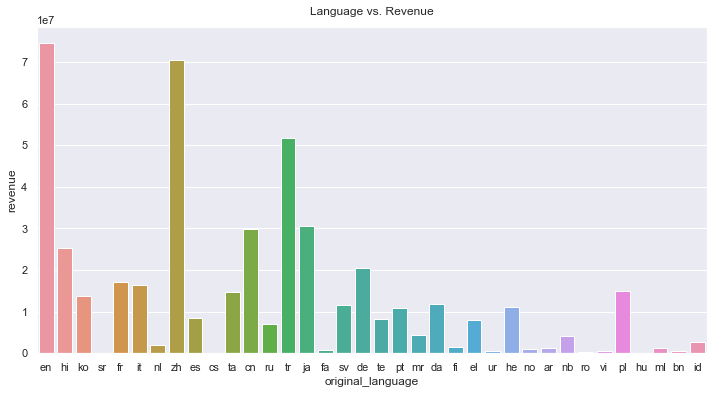

In [57]:
plt.figure(figsize=(12, 6))
sns.barplot(x=train['original_language'], y=train['revenue'], data=train, ci=0)
plt.title('Language vs. Revenue', fontsize=12, pad=12);

### overview

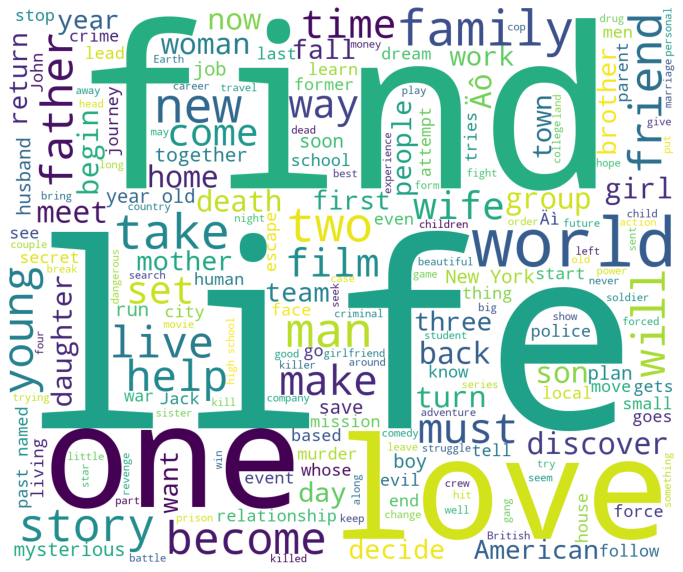

In [58]:
plt.figure(figsize=(12, 12))
text = ' '.join(train['overview'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.axis('off');

In [59]:
vectorizer = TfidfVectorizer(
            sublinear_tf=True,
            analyzer='word',
            token_pattern=r'\w{1,}',
            ngram_range=(1, 2),
            min_df=5)

overview_text = vectorizer.fit_transform(train['overview'].fillna(''))
linreg = LinearRegression()
linreg.fit(overview_text, train['log_revenue'])
eli5.show_weights(linreg, vec=vectorizer, top=20, feature_filter=lambda x: x != '<BIAS>')

In [60]:
print('Target value:', train['log_revenue'][1000])

Target value: 16.445839477020453


In [61]:
eli5.show_prediction(linreg, doc=train['overview'].values[1000], vec=vectorizer)

### release date

In [62]:
test.loc[test['release_date'].isnull() == True, 'release_date'] = '01/01/98'

In [63]:
# fix year from 20, 19 to 2000+ and 1900+
def fix_date(x):
    year = x.split('/')[2]
    if int(year) <= 19:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year

In [64]:
train['release_date'] = train['release_date'].apply(lambda x : fix_date(x))
test['release_date'] = test['release_date'].apply(lambda x : fix_date(x))

train['release_date'] = pd.to_datetime(train['release_date'])
test['release_date'] = pd.to_datetime(test['release_date'])

In [65]:
# creating features based on dates
def process_date(df):
    date_parts = ['year','weekday','month','day','quarter']
    for part in date_parts:
        part_col = 'release_date' + '_' + part
        df[part_col] = getattr(df['release_date'].dt, part).astype(int)
        
    return df

train = process_date(train)
test = process_date(test)

In [66]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = test['release_date_year'].value_counts().sort_index()

data = [go.Scatter(x=d1.index, y=d1.values, name='train'), go.Scatter(x=d2.index, y=d2.values, name='test')]
layout = go.Layout(dict(title = "Number of films per year",
                   xaxis = dict(title = 'Year'),
                   yaxis = dict(title = 'Count')),legend=dict(orientation="v"))

py.iplot(dict(data=data, layout=layout))

In [67]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby(['release_date_year'])['revenue'].sum()

data = [go.Scatter(x=d1.index, y=d1.values, name='film count'), 
        go.Scatter(x=d2.index, y=d2.values, name='total revenue', yaxis='y2')]
layout = go.Layout(dict(title = "Number of films and total revenue per year",
                   xaxis = dict(title = 'Year'),
                   yaxis = dict(title = 'Count'),
                   yaxis2 = dict(title='Total revenue', overlaying='y', side='right')),
                   legend = dict(orientation="v"))

py.iplot(dict(data=data, layout=layout))

In [68]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby(['release_date_year'])['revenue'].mean()

data = [go.Scatter(x=d1.index, y=d1.values, name='film count'), 
        go.Scatter(x=d2.index, y=d2.values, name='mean revenue', yaxis='y2')]
layout = go.Layout(dict(title = "Number of films and average revenue per year",
                   xaxis = dict(title = 'Year'),
                   yaxis = dict(title = 'Count'),
                   yaxis2 = dict(title='Average revenue', overlaying='y', side='right')),
                   legend = dict(orientation="v"))

py.iplot(dict(data=data, layout=layout))

In [69]:
# sns.catplot(x='release_date_weekday', y='revenue', data=train);
# plt.title('Movies Release Time (Monday - Sunday)');

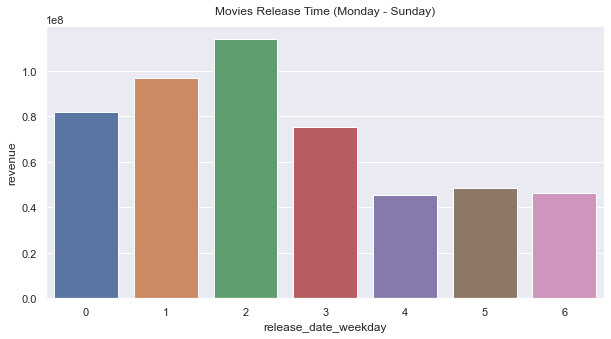

In [70]:
plt.figure(figsize=(10, 5))
sns.barplot(x='release_date_weekday', y='revenue', data=train, ci=0)
plt.title('Movies Release Time (Monday - Sunday)', fontsize=12, pad=12);

### runtime
The length of the film in minutes

/Users/zhuoquanchen/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning:

invalid value encountered in greater_equal

/Users/zhuoquanchen/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning:

invalid value encountered in less_equal



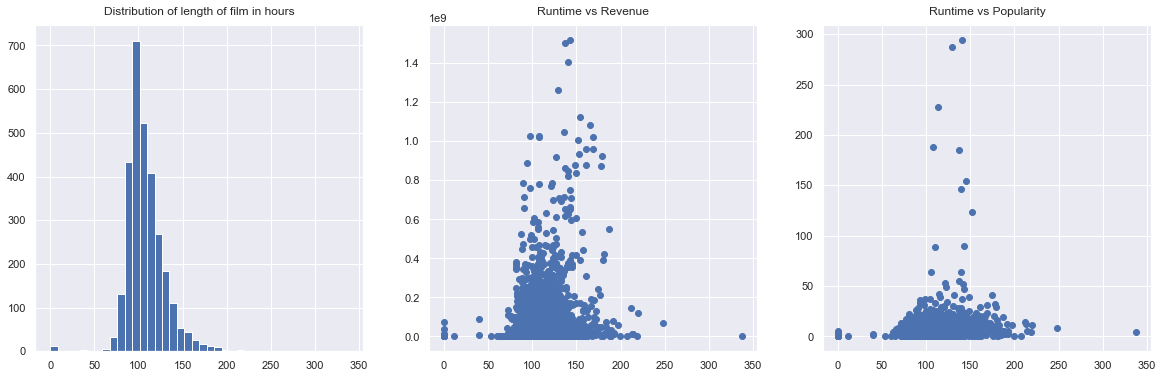

In [71]:
fig, ax = plt.subplots(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.hist(train['runtime'], bins=40)
plt.title('Distribution of length of film in hours', fontsize=12, pad=10)

plt.subplot(1, 3, 2)
plt.scatter(train['runtime'], train['revenue'])
plt.title('Runtime vs Revenue', fontsize=12, pad=10)

plt.subplot(1, 3, 3)
plt.scatter(train['runtime'], train['popularity'])
plt.title('Runtime vs Popularity', fontsize=12, pad=10);

The the run time, reveneu and popularity of the most film is in the range of 1.5 to 2 hours

### genres

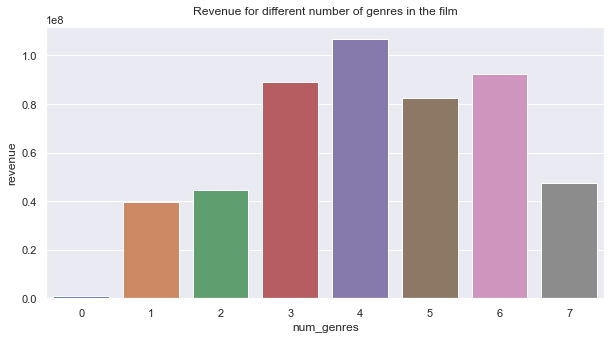

In [72]:
plt.figure(figsize=(10, 5))
sns.barplot(x='num_genres', y='revenue', data=train, ci=0)
plt.title('Revenue for different number of genres in the film', fontsize=12, pad=12);

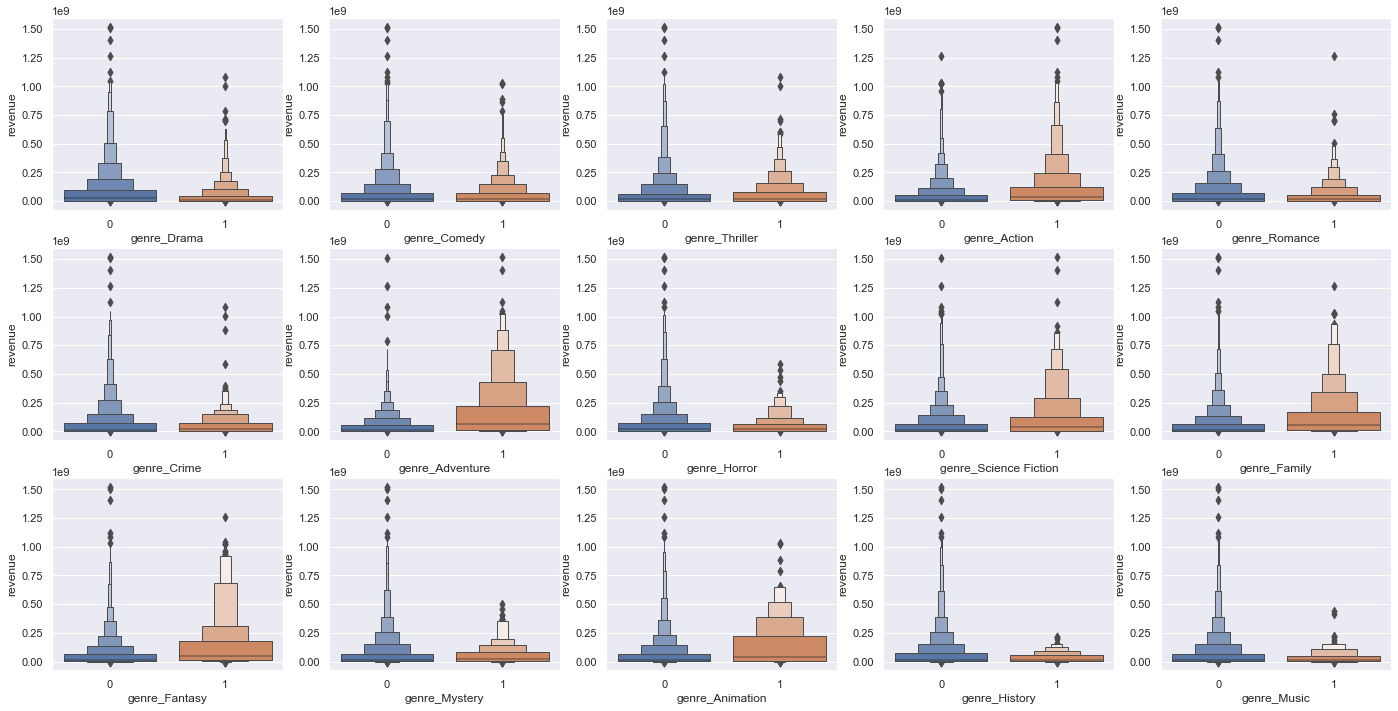

In [73]:
fig, ax = plt.subplots(3, 5, figsize=(24, 12))
for i, e in enumerate([col for col in train.columns if 'genre_' in col]):
    sns.boxenplot(x=e, y='revenue', data=train, ax=ax[i // 5][i % 5]);

### production companies

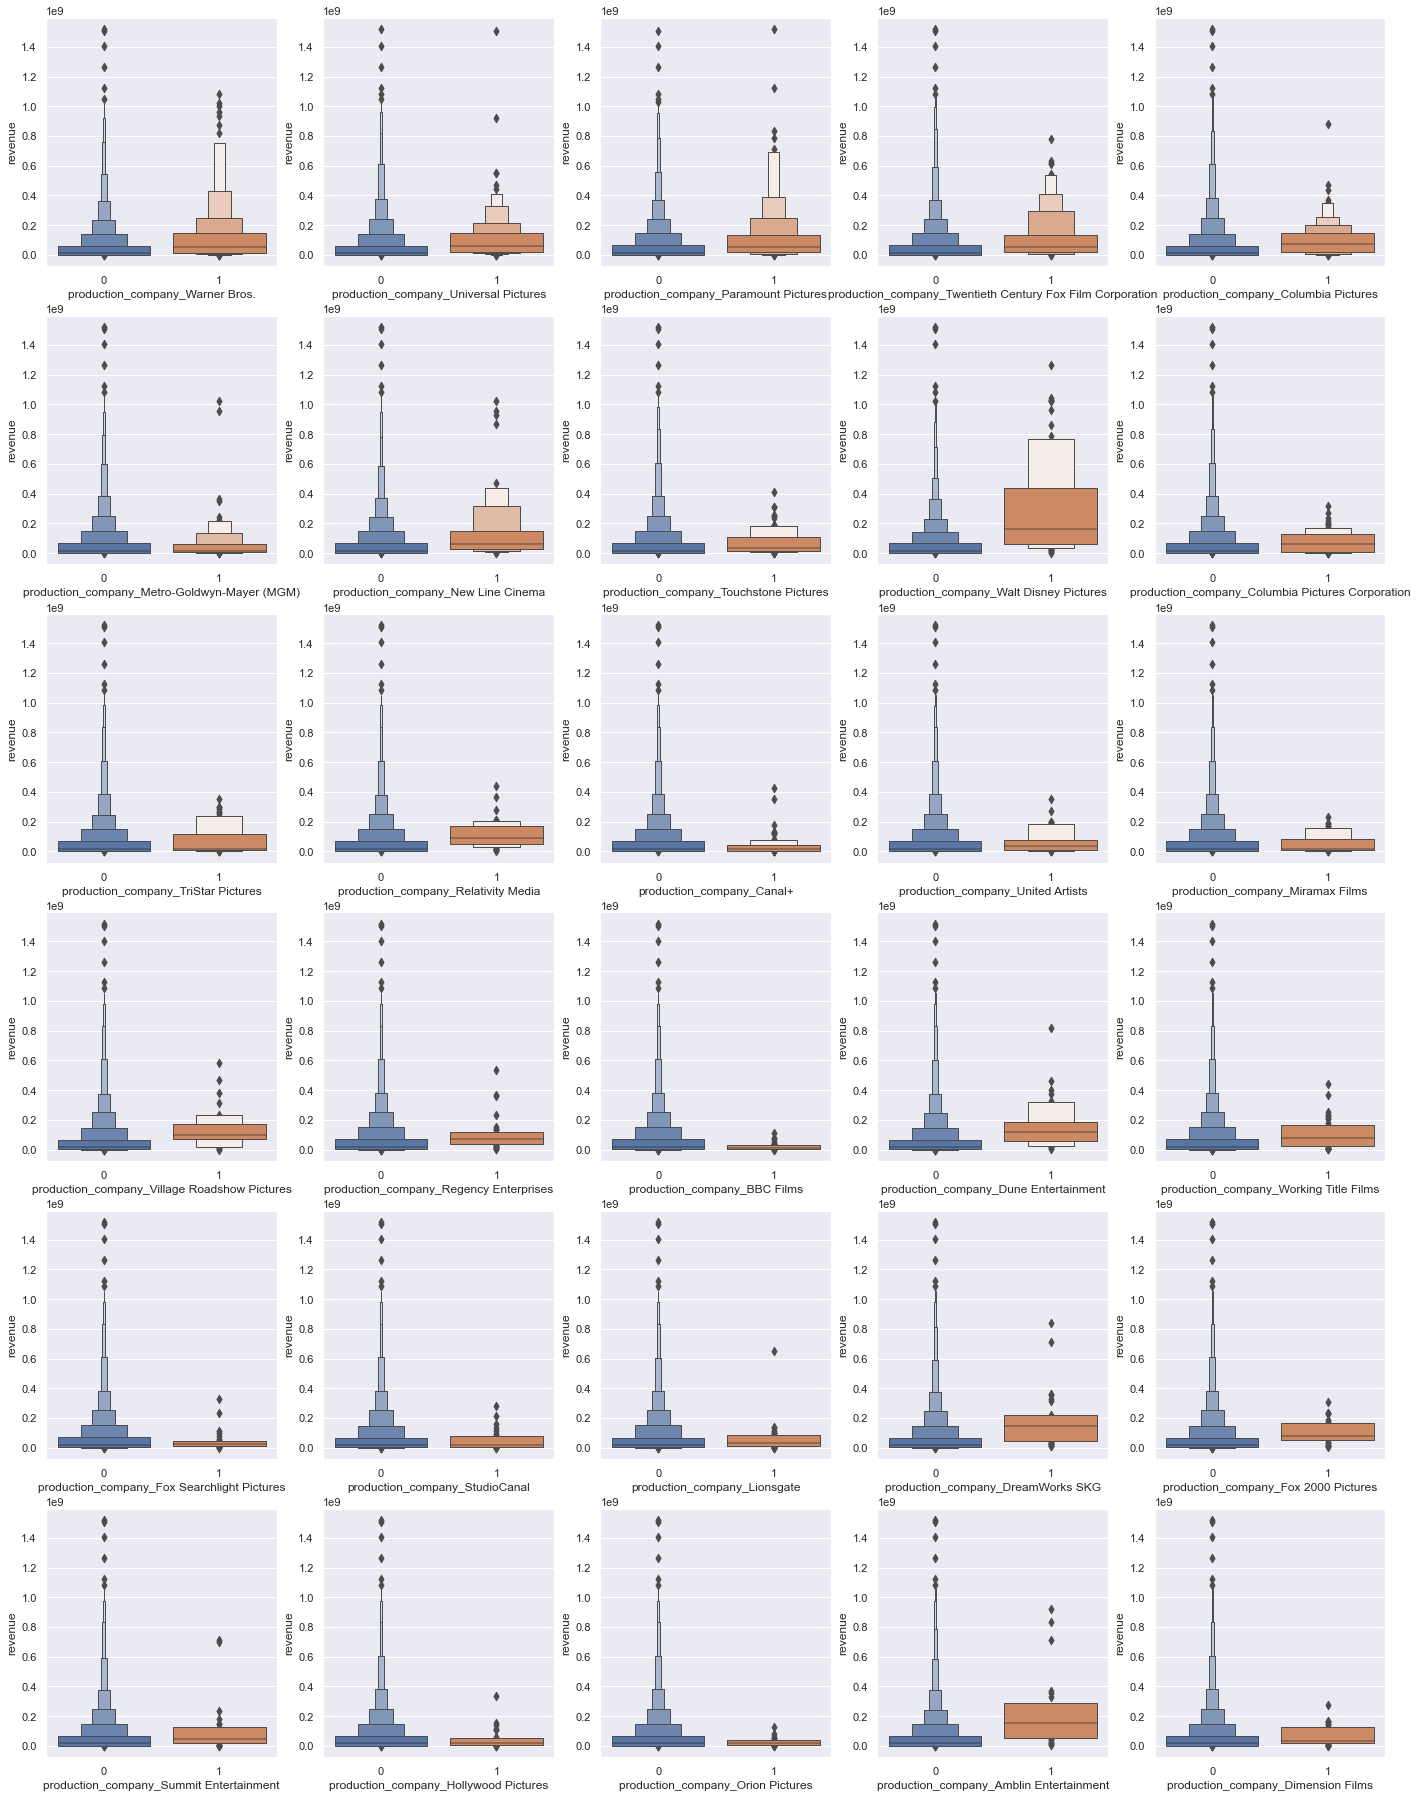

In [74]:
fig, ax = plt.subplots(6, 5, figsize=(24, 32))
for i, e in enumerate([col for col in train.columns if 'production_company' in col]):
    sns.boxenplot(x=e, y='revenue', data=train, ax=ax[i // 5][i % 5]);

### production countries

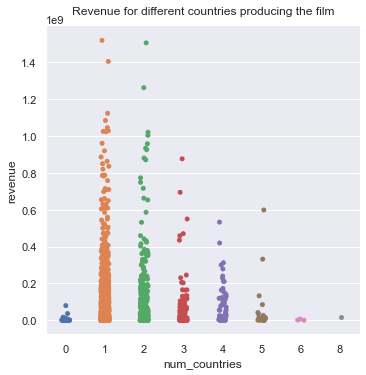

In [75]:
sns.catplot(x='num_countries', y='revenue', data=train)
plt.title('Revenue for different countries producing the film', fontsize=12, pad=12);

### cast

Text(0.5, 1.0, 'Number of cast members vs log revenue')

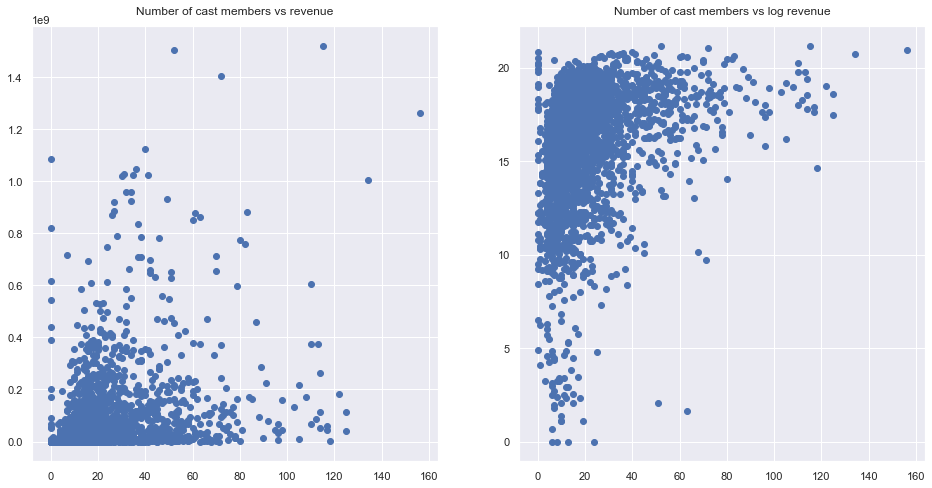

In [76]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(x='num_cast', y='revenue', data=train)
plt.title('Number of cast members vs revenue', fontsize=12, pad=12)

plt.subplot(1, 2, 2)
plt.scatter(x='num_cast', y='log_revenue', data=train)
plt.title('Number of cast members vs log revenue', fontsize=12, pad=12)

### crew

Text(0.5, 1.0, 'Number of crew members vs log revenue')

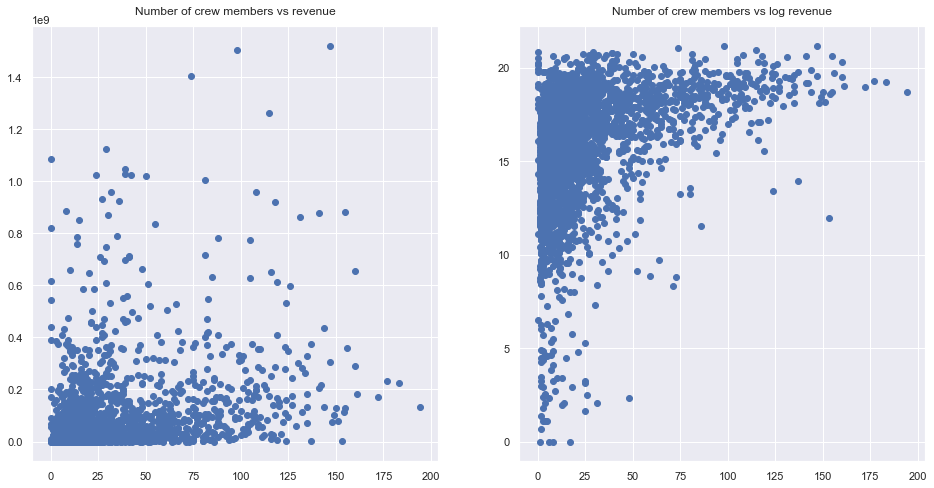

In [77]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(x='num_crew', y='revenue', data=train)
plt.title('Number of crew members vs revenue', fontsize=12, pad=12)

plt.subplot(1, 2, 2)
plt.scatter(x='num_crew', y='log_revenue', data=train)
plt.title('Number of crew members vs log revenue', fontsize=12, pad=12)

## Medoling

In [78]:
# train_texts = train[['title', 'overview']]
# test_texts = test[['title', 'overview']]

In [79]:
train = train.drop(['homepage', 'imdb_id', 'poster_path', 'release_date', 'status', 'log_revenue', 'tagline',
                    'original_language', 'collection_name', 'all_genres', 'original_title', 
                    'title', 'overview'], axis=1)
test = test.drop(['homepage', 'imdb_id', 'poster_path', 'release_date', 'status', 'original_language', 'tagline',
                  'collection_name', 'all_genres', 'original_title', 'title', 'overview'], axis=1)

In [80]:
train.head(1)

,id,budget,popularity,runtime,revenue,has_collection,num_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,production_company_Regency Enterprises,production_company_BBC Films,production_company_Dune Entertainment,production_company_Working Title Films,production_company_Fox Searchlight Pictures,production_company_StudioCanal,production_company_Lionsgate,production_company_DreamWorks SKG,production_company_Fox 2000 Pictures,production_company_Summit Entertainment,production_company_Hollywood Pictures,production_company_Orion Pictures,production_company_Amblin Entertainment,production_company_Dimension Films,num_countries,production_country_United States of America,production_country_United Kingdom,production_country_France,production_country_Germany,production_country_Canada,production_country_India,production_country_Italy,production_country_Japan,production_country_Australia,production_country_Russia,production_country_Spain,production_country_China,production_country_Hong Kong,production_country_Ireland,production_country_Belgium,production_country_South Korea,production_country_Mexico,production_country_Sweden,production_country_New Zealand,production_country_Netherlands,production_country_Czech Republic,production_country_Denmark,production_country_Brazil,production_country_Luxembourg,production_country_South Africa,production_country_Hungary,production_country_United Arab Emirates,production_country_Austria,production_country_Switzerland,production_country_Romania,num_languages,language_English,language_Français,language_Español,language_Deutsch,language_Pусский,language_Italiano,language_日本語,language_普通话,language_हिन्दी,language_,language_Português,language_العربية,language_한국어/조선말,language_广州话 / 廣州話,language_தமிழ்,language_Polski,language_Magyar,language_Latin,language_svenska,language_ภาษาไทย,language_Český,language_עִבְרִית,language_ελληνικά,language_Türkçe,language_Dansk,language_Nederlands,language_فارسی,language_Tiếng Việt,language_اردو,language_Română,num_Keywords,keyword_woman director,keyword_independent film,keyword_duringcreditsstinger,keyword_murder,keyword_based on novel,keyword_violence,keyword_sport,keyword_biography,keyword_aftercreditsstinger,keyword_dystopia,keyword_revenge,keyword_friendship,keyword_sex,keyword_suspense,keyword_sequel,keyword_love,keyword_police,keyword_teenager,keyword_nudity,keyword_female nudity,keyword_drug,keyword_prison,keyword_musical,keyword_high school,keyword_los angeles,keyword_new york,keyword_family,keyword_father son relationship,keyword_kidnapping,keyword_investigation,num_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_Morgan Freeman,cast_name_J.K. Simmons,cast_name_Bruce Willis,cast_name_Liam Neeson,cast_name_Susan Sarandon,cast_name_Bruce McGill,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,cast_name_Jason Statham,cast_name_Keith David,cast_name_John Goodman,cast_name_Mel Gibson,cast_name_Sigourney Weaver,gender_0_cast,gender_1_cast,gender_2_cast,num_crew,crew_name_Avy Kaufman,crew_name_Robert Rodriguez,crew_name_Deborah Aquila,crew_name_

In [99]:
train['runtime'].fillna(90.0, inplace=True)

In [103]:
test['runtime'].fillna(100.0, inplace=True)

In [106]:
X = train.drop(['id', 'revenue'], axis=1)
y = np.log1p(train['revenue'])
X_test = test.drop(['id'], axis=1)

In [107]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

In [108]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)

In [109]:
# for col in train_texts.columns:
#     vectorizer = TfidfVectorizer(
#                 sublinear_tf=True,
#                 analyzer='word',
#                 token_pattern=r'\w{1,}',
#                 ngram_range=(1, 2),
#                 min_df=10)
#     vectorizer.fit(list(train_texts[col].fillna('')) + list(test_texts[col].fillna('')))
#     train_col_text = vectorizer.transform(train_texts[col].fillna(''))
#     test_col_text = vectorizer.transform(test_texts[col].fillna(''))

In [110]:
# print(train_col_text)

In [111]:
gboost_pipe = Pipeline (steps = [
    ('ss', StandardScaler()),
    ('gboost', GradientBoostingRegressor())
])

gboost_pipe.fit(X_train_sc, y_train)

print('gboost training score is:', gboost_pipe.score(X_train_sc, y_train))
print('gboost testing score is:', gboost_pipe.score(X_val_sc, y_val))

gboost training score is: 0.6719741575560858
gboost testing score is: 0.5349441786671179
